# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

完成并连同作业缴交此完整的工作表(包括其输出及工作表外的任何支援程式码)。更多详情请参见课程网站上的[作业页]。*

kNN分类器分为两个阶段:

-训练时，分类器获取训练数据并简单记忆
-在测试过程中，kNN将每个测试图像与所有的训练图像进行比较，并将k个最相似的训练实例的标签进行转移，从而对每个测试图像进行分类
- k的值是交叉验证的

在本练习中，您将实现这些步骤并了解基本的图像分类管道、交叉验证，并熟练地编写高效的向量化代码。


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
# 使matplotlib图形内联出现在笔记本中，而不是出现在新窗口中，这有点神奇。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# 一些更神奇的，使笔记本将重新加载外部python模块;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
# cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
cifar10_dir = 'E:\cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
# 清除变量以防止多次加载数据(这可能会导致内存问题)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
# 作为一个完整性检查，我们打印出训练和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


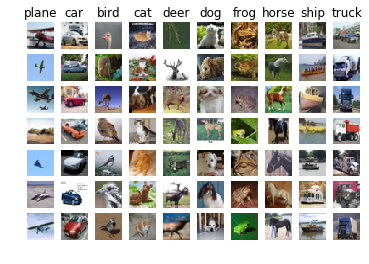

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
# 在本练习中，为了更有效地执行代码，对数据进行了细分
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
# 创建一个kNN分类器实例。
# 记住，训练一个kNN分类器是一个noop:
# 分类器只记住数据，不做进一步的处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.


我们现在想用kNN分类器对测试数据进行分类。我们可以把这个过程分成两个步骤:

首先，我们必须计算所有测试样例和所有训练样例之间的距离。

给定这些距离，对于每个测试示例，我们找到k个最近的示例，并让它们为标签投票

让我们从计算所有训练和测试示例之间的距离矩阵开始。

例如，如果有Ntr训练示例和Nte测试示例，则此阶段应该生成Nte x Ntr矩阵，其中每个元素(i,j)是第i个测试和第j个训练示例之间的距离。

注意:对于我们要求您在本笔记本中实现的三个距离计算，您可能不使用numpy提供的np.linalg.norm()函数。

首先，打开`cs231n/classifiers/k_nearest_neighbor.py` 并实现`compute_distances_two_loops`函数，该函数在所有对(测试、培训)示例上使用一个(非常低效的)双循环，并一次计算一个元素的距离矩阵。

In [6]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


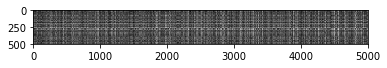

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
# 我们可以可视化距离矩阵：每一行都是一个测试示例 和 它与训练示例的距离
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. 

(Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*

注意距离矩阵中的结构化模式，其中一些行或列更亮。

(注意，在默认的配色方案中，黑色表示低距离，白色表示高距离。)

-数据中那些明显明亮的行背后的原因是什么?
-是什么导致了这些列?


In [8]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
# 计算并打印正确预测的示例的分数
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. 

Now lets try out a larger `k`, say `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$


In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. 
# 现在，通过使用一个循环的部分矢量化来加快距离矩阵的计算。
# Implement the function compute_distances_one_loop and run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
# 为了确保向量化的实现是正确的，我们要确保它与初始实现是一致的。
# 判断两个矩阵是否相似的方法有很多种;其中最简单的是Frobenius范数。
# 如果你以前没见过，两个矩阵的Frobenius范数是所有元素的差的平方和的平方根;
# 换句话说，将矩阵重新组合成向量并计算它们之间的欧氏距离。

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
# 现在在compute_distances_no_loops内部实现完全矢量化的版本并运行代码
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
# 检查距离矩阵是否与我们之前计算出的矩阵一致：
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!
# 使用完全矢量化的实现，您应该会看到明显更快的性能！
# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.
# 根据所用的计算机，当您从两个循环转到一个循环时，您可能看不到加速，甚至可能会发现速度变慢。

Two loop version took 45.506625 seconds
One loop version took 82.338715 seconds
No loop version took 0.427333 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. 

We will now determine the best value of this hyperparameter with cross-validation.

我们已经实现了k最近邻居分类器，但是我们可以任意设置值k = 5。 

现在，我们将通过交叉验证确定此超参数的最佳值。

In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 将训练数据分成多个部分。
# 拆分后，X_train_folds和y_train_folds都应为长度为num_folds的列表，
# 其中y_train_folds [i]是X_train_folds [i]中各点的标签矢量。
# 提示：查找numpy array_split函数。
X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
# 一个字典，包含我们在进行交叉验证时发现的k的不同值的精度。
# 运行交叉验证后，k_to_accuracies [k]应该是长度num_folds的列表，
# 其中给出了使用k的值时发现的不同精度值。
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 执行 k-fold 交叉验证，以找到k的最佳值。
# 对于k的每个可能值，运行k_nearest-neighbor算法num_folds次，
# 在每种情况下，您将其中一个fold以外的所有折叠用作训练数据，将最后一个fold用作验证集。
# 将所有fold和所有k值的精度存储在k_to_accuracies字典中。
pass

# '''
for k_val in k_choices:
#   print 'k = '+str(k_val)
  k_to_accuracies[k_val]=[]
  for i in range(num_folds):
    # print 'Cross-validation :'+ str(i)
    X_train_cycle = np.concatenate([f for j,f in enumerate(X_train_folds) if j!=i ])
    y_train_cycle = np.concatenate([f for j,f in enumerate(y_train_folds) if j!=i ])
    X_val_cycle = X_train_folds[i]
    y_val_cycle = y_train_folds[i]
    #initialize the KNN
    knn = KNearestNeighbor()
    knn.train(X_train_cycle,y_train_cycle)
    #calculate the accuracy
    y_val_pred = knn.predict(X_val_cycle,k_val, 0)
    num_correct = np.sum(y_val_cycle == y_val_pred)
    k_to_accuracies[k_val].append(float(num_correct) / float(len(y_val_cycle)))
# '''

'''有bug
for ki in k_choices:
    for fi in range(num_folds):
        #prepare the data
        valindex=fi
        X_traini = np.vstack((X_train_folds[0:fi]+X_train_folds[fi+1:num_folds]))
        y_traini = np.hstack((y_train_folds[0:fi]+ y_train_folds[fi+1:num_folds]))
        X_vali = np.array(X_train_folds[valindex])
        y_vali = np.array(y_train_folds[valindex])
        num_val=len(y_vali)
        #initialize the KNN
        classifier = KNearestNeighbor()
        classifier.train(X_traini,y_traini)
        #calculate the accuracy
        dists = classifier.compute_distances_one_loop(X_vali)
        y_val_pred = classifier.predict_labels(dists, k=ki)
        num_correct = np.sum(y_val_pred == y_vali)
        accuracy = float(num_correct) / num_val
        print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[ki].append(accuracy)
'''    

'''有bug
for k_ in k_choices:
    k_to_accuracies.setdefault(k_, [])
for i in range(num_folds):
    classifier = KNearestNeighbor()
    X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
    y_val_train = np.vstack(y_train_folds[0:i] + y_train_folds[i+1:])
    y_val_train = y_val_train[:,0]
    classifier.train(X_val_train, y_val_train)
    for k_ in k_choices:
        y_val_pred = classifier.predict(X_train_folds[i], k=k_)
        num_correct = np.sum(y_val_pred == y_train_folds[i][:,0])
        accuracy = float(num_correct) / len(y_val_pred)
        k_to_accuracies[k_] = k_to_accuracies[k_] + [accuracy]
'''   

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

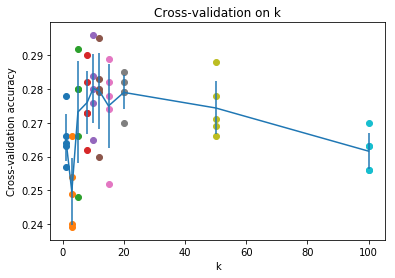

In [17]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [18]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
# 根据上面的交叉验证结果，为k选择最佳值，
# 使用所有训练数据重新训练分类器，然后在测试数据上对其进行测试。
# 您应该能够在测试数据上获得28％以上的准确性。
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.

以下是关于k最近邻（k-NN）的以下哪个陈述在分类设置中正确，并且对于所有k？ 选择所有符合条件的。

1. The decision boundary of the k-NN classifier is linear.

k-NN分类器的决策边界是线性的。

2. The training error of a 1-NN will always be lower than that of 5-NN.

1-NN的训练误差将始终低于5-NN。

3. The test error of a 1-NN will always be lower than that of a 5-NN.

1-NN的测试误差将始终低于5-NN。

4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.

使用k-NN分类器对测试示例进行分类所需的时间随训练集的大小而增加。

5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

